In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/5y'

djia_tickers = [
    'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
    'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
    'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

In [3]:
def get_dataframe_from_ticker(ticker_symbol):
    r = requests.get(url = IEX_API_URL_TEMPLATE.format(ticker_symbol.lower()))
    df = json_normalize(r.json())

    df.insert(loc=0, column='symbol', value=ticker_symbol)

    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)

    df = df.drop(['label',
                  'change', 'changeOverTime', 'changePercent',
                  'high', 'low', 'open',
                  'unadjustedVolume', 'volume', 'vwap'],
                 axis=1)

    return df

In [4]:
def split_into_train_and_validation(df, validation_days):

    start_train_date = min(df.date)
    end_validation_date = max(df.date)
    end_train_date = end_validation_date - datetime.timedelta(days=validation_days)
    
    train = df.query("date >= '{}' and date <= '{}'".format(start_train_date, end_train_date))
    validation = df.query("date > '{}' and date <= '{}'".format(end_train_date, end_validation_date))

    return train, validation

In [5]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### -------

In [6]:
aapl_hist = get_dataframe_from_ticker('AAPL')
aapl_hist.dtypes

symbol               object
close               float64
date         datetime64[ns]
year                  int64
month                 int64
day                   int64
week                  int64
dayofweek             int64
dayofyear             int64
timestamp             int64
dtype: object

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


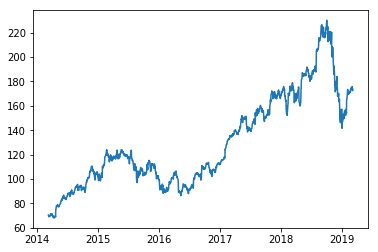

In [7]:
plt.plot(aapl_hist.date, aapl_hist.close, label='Close Price history')

In [8]:
#aapl_train, aapl_validation = split_into_train_validation(aapl_hist, '2015-01-01', '2018-12-31', '2019-03-08')
aapl_train, aapl_validation = split_into_train_and_validation(aapl_hist, 84)

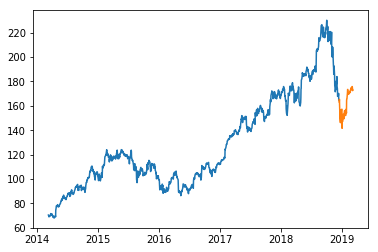

In [9]:
plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')

### -----------

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
x = aapl_train.drop(['symbol', 'date', 'close'], axis=1)
y = aapl_train.close

model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

26.932490967242092


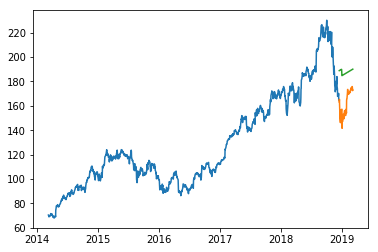

In [12]:
preds = model.predict(aapl_validation.drop(['symbol', 'date', 'close'], axis=1))

print(rmse(preds, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, preds, label='Prediction')

### --------

In [13]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.5/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [14]:
train = aapl_train['close']

model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5129.572, BIC=5154.976, Fit time=8.990 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5875.431, BIC=5885.593, Fit time=0.140 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5585.856, BIC=5606.179, Fit time=1.894 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5129.457, BIC=5149.780, Fit time=11.184 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5131.450, BIC=5156.854, Fit time=9.224 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5876.183, BIC=5891.425, Fit time=0.464 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5131.449, BIC=5156.854, Fit time=28.179 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5132.587, BIC=5163.072, Fit time=36.094 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=5128.686, BIC=5143.928, Fit time=4.022 seconds
Fit ARIMA: order=(0, 1, 0

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

9.911930607795883


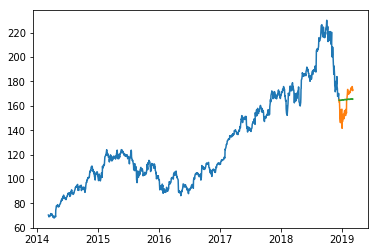

In [15]:
validation = aapl_validation['close']

forecast = model.predict(n_periods=validation.shape[0])
#forecast = pd.DataFrame(forecast, index = aapl_validation.date, columns=['prediction'])

print(rmse(forecast, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, forecast, label='Prediction')

### ----------------

In [16]:
from fbprophet import Prophet

In [17]:
train = pd.DataFrame(aapl_train, columns=['date', 'close'])
train.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

model = Prophet()
model.fit(train)

/usr/local/lib/python3.5/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
close_prices = model.make_future_dataframe(periods=validation.shape[0])
forecast = model.predict(close_prices)['yhat'][train.shape[0]:]

46.10732599998221


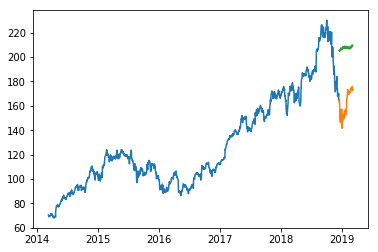

In [19]:
print(rmse(forecast, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, forecast, label='Prediction')

### ---------------------

In [20]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [21]:
P = 60 # timesteps

In [22]:
train = pd.DataFrame(aapl_train, columns=['close'])

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

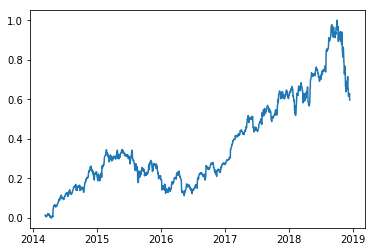

In [24]:
plt.plot(aapl_train.date, scaled_train, label='Scaled Training')

In [25]:
x_train, y_train = [], []
for i in range(P, len(train)):
    x_train.append(scaled_train[i-P:i, 0])
    y_train.append(scaled_train[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 291s - loss: 0.0022


In [34]:
total_dataset = pd.concat((aapl_train.close, aapl_validation.close), axis = 0)
inputs = total_dataset[len(total_dataset) - len(aapl_validation) - P:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [45]:
X_test = []
for i in range(P, inputs.shape[0]):
    X_test.append(inputs[i-P:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price.reshape(-1)

8.483809745055337


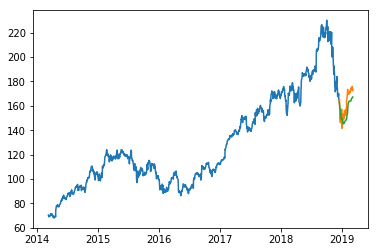

In [47]:
print(rmse(closing_price, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, closing_price, label='Prediction')

147.0923831373527


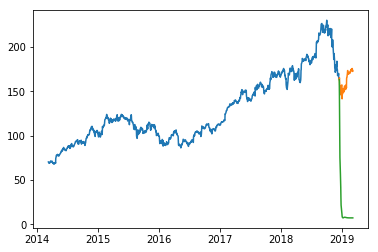

In [52]:
total_dataset = pd.concat((aapl_train.close, pd.DataFrame(0, index=range(56), columns=range(1))), axis = 0)
inputs = total_dataset[len(total_dataset) - len(aapl_validation) - P:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(P, inputs.shape[0]):
    X_test.append(inputs[i-P:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price.reshape(-1)

print(rmse(closing_price, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, closing_price, label='Prediction')

(60,)
36.68157016530232


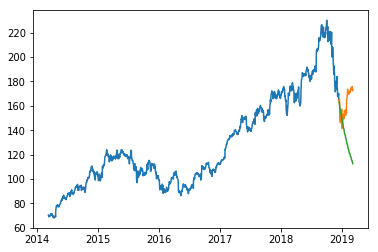

In [89]:
inputs = aapl_train.close[len(aapl_train) - P:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs).reshape(-1)
#inputs = np.asarray(inputs).reshape(-1)
print(inputs.shape)

closing_price = []

for i in range(0, 56):
    #X_test = np.array([inputs[i:i+P, 0]])
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #print(X_test.shape)
    X_test = np.array(inputs[i:i+P])
    X_test = np.reshape(X_test, (1, P, 1))

    pred = model.predict(X_test)
    closing_price.append(scaler.inverse_transform(pred).reshape(-1)[0])
    inputs = np.append(inputs, pred)



print(rmse(closing_price, aapl_validation.close))

plt.plot(aapl_train.date, aapl_train.close, label='Training')
plt.plot(aapl_validation.date, aapl_validation.close, label='Validation')
plt.plot(aapl_validation.date, closing_price, label='Prediction')